# GEM radix Lagrangean decomposition

In [1]:
REG_WEIGHT   = 0. #1e-4
MAX_NONZERO  = None #48*2
PREVENT_ZERO = True
TWO_PHASE    = True

In [2]:
%load_ext line_profiler

In [3]:
from gurobipy import *

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['svg.fonttype'] = 'none'
pd.set_option('display.max_colwidth', -1)
%matplotlib inline

from cobra.io import load_json_model
from six import iteritems
import numpy as np
import cobra

In [4]:
#ijomc = load_json_model('/home/laurence/ME/models/e_coli_core_pc.json')
ijomc = load_json_model('/home/laurence/ME/data/dynamicME/nominal_ijomc.json')

In [5]:
print(ijomc.optimize())
mu_crowd0 = ijomc.reactions.BIOMASS_Ec_iJO1366_core_53p95M
print(mu_crowd0)

<Solution 0.97 at 0x7f5681cd5e50>
BIOMASS_Ec_iJO1366_core_53p95M


In [6]:
df_meas = pd.read_csv('/home/laurence/ME/data/dynamicME/beg/growth_meas.csv')

ex_rxns = [r for r in df_meas.ex_rxn.unique() if ijomc.reactions.has_id(r)]
df_meas = df_meas[ df_meas.ex_rxn.isin(ex_rxns)]
conds = df_meas.substrate.unique()

#N_CONDS = len(conds)
N_CONDS = 2

df_conds = pd.DataFrame([{'cond':r['substrate'], 'rxn':ex_rxn, 'lb':-10 if r['ex_rxn']==ex_rxn else 0, 'ub':1000., 'obj':0.} for i,r in df_meas.iterrows() for ex_rxn in ex_rxns])

if N_CONDS==1:
    df_conds = df_conds[ df_conds.cond=='acetate']
elif N_CONDS<=3:
    df_conds = df_conds[ df_conds.cond.isin(['glucose','acetate','succinate'][0:N_CONDS])]
else:
    df_conds = df_conds[ df_conds.cond.isin(conds[0:N_CONDS])]

df_conds.loc[ (df_conds.cond=='acetate') & (df_conds.rxn=='EX_ac_e'), 'lb'] = -20

# Make radix problem

In [7]:
from dynamicme.estimate import RadixEstimator

In [8]:
df_Y = df_meas.rename(columns={'growth_rate_1_h':'output', 'substrate':'cond'})
df_Y.loc[:,'output_id'] = 'BIOMASS_Ec_iJO1366_core_53p95M'
df_X = df_conds

In [9]:
from dynamicme.decomposition import LagrangeMaster, LagrangeSubmodel

In [10]:
conds = df_conds.cond.unique()
sub_dict = {}
for cond in conds:
    df_Xk = df_X[ df_X.cond==cond]
    df_Yk = df_Y[ df_Y.cond==cond]
    estk = RadixEstimator()
    estk.fit(ijomc, df_Xk, df_Yk, reg_weight = REG_WEIGHT, max_nonzero_binaries=MAX_NONZERO, optimize=False)    
    sub = LagrangeSubmodel(estk.stacker.model, cond)
    sub_dict[cond] = sub

Changed value of parameter OutputFlag to 1
   Prev: 0  Min: 0  Max: 1  Default: 1
Changed value of parameter OutputFlag to 1
   Prev: 0  Min: 0  Max: 1  Default: 1


In [ ]:
master = LagrangeMaster(estk.stacker.model)
master.add_submodels(sub_dict)

### Two-phase

In [ ]:
master.time_limit = 2*3600
#master.max_iter = 500
master.verbosity = 2
master.print_iter = 5
master.gaptol = 1e-3
master.absgaptol = 1e-3
feasible_method = 'enumerate'
alt_method = 'pool'
max_alt = 10    # Computationally expensive if too large. Might miss feasible solution if too small.
                # Can make adaptive if no feasible solution found for certain iterations.
if TWO_PHASE:
    sol_master = master.solve_relaxed(feasible_method=None)
    df_phase1 = pd.DataFrame(master.log_rows)
    
sol_master = master.optimize(feasible_method=feasible_method, max_alt=max_alt, alt_method=alt_method,
                            nogood_cuts = True) 
df_phase2 = pd.DataFrame(master.log_rows)

    Iter                    UB                    LB       gap relgap(%)   penalty                       Time(s)
  ------   -------------------   -------------------  -------- ---------  -------- -----------------------------
               Best   Feasible        Sub       Best                                   total    master       sub
       0       1000     1e+100 -8.574e-08 -8.574e-08      1000       100  1.24e-18  2.003705  0.019361  1.968717
       5      3.393     1e+100     -179.6 -8.574e-08     3.393       100      1.21  43.73659  0.034999  10.12896
      10      14.63     1e+100      -3208 -8.574e-08     14.63       100      7.13  90.02098  0.040559  6.134618
      15         49     1e+100 -2.964e+04 -8.574e-08        49       100      22.2  124.8292  0.047395  4.694406
      20      61.85     1e+100 -1.841e+05 -8.574e-08     61.85       100        17  145.4471  0.057092  4.436564
      25      38.89     1e+100  -4.76e+05 -8.574e-08     38.89       100      3.56  160.6579  0.

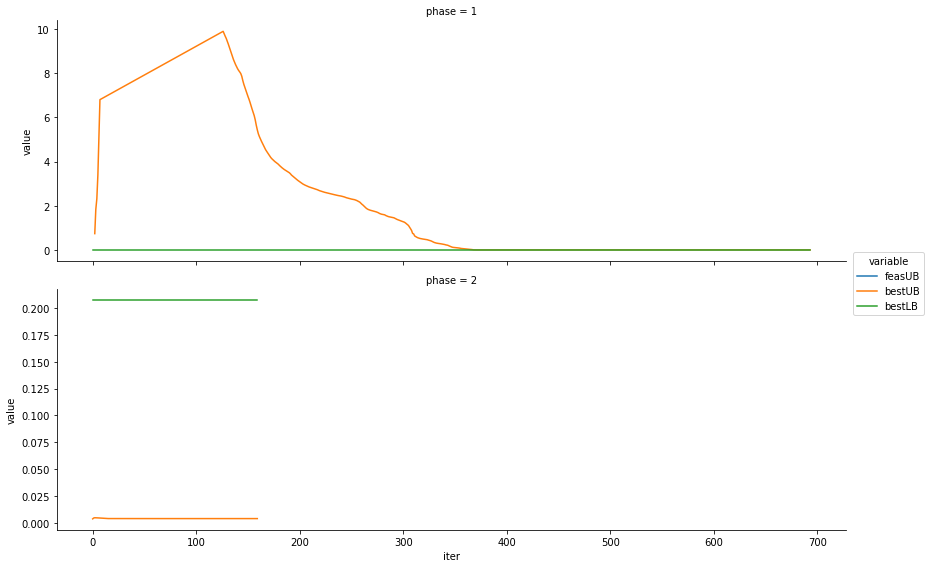

In [16]:
xcol = 'iter'
df_phase1.loc[:,'phase'] = 1
df_phase2.loc[:,'phase'] = 2
dsplot = pd.concat([df_phase1, df_phase2])
dsplot = dsplot[[xcol,'feasUB','bestUB','bestLB','phase']]
dsplot = dsplot.melt(id_vars=[xcol,'phase'])
dsplot.loc[ dsplot.value>1e1, 'value'] = np.nan
dsplot.loc[ dsplot.value<-1e1, 'value'] = np.nan

g = sns.FacetGrid(dsplot, hue='variable', size=4, aspect=3, row='phase', sharey=False)
g.map(plt.plot, xcol,'value')
g.add_legend()

In [17]:
var_cons_dict = estk.var_cons_dict
powers = estk.powers
digits = estk.digits
radix  = estk.radix

In [31]:
if sol_master is None:
    sol_masterk = sub.x_dict

In [32]:
kfit_dict = {}
for group_id, var_dict in iteritems(var_cons_dict):
    var = var_dict[0]
    cons = var_dict[1]
    a0  = var_dict[0][2]
    kfit = 0.
    for l,pwr in enumerate(powers):
        for k,digit in enumerate(digits):            
            yid = 'binary_%s%s%s' % (group_id,k,l)
            y   = sol_masterk[yid]
            kfit += y*a0*radix**pwr*digit
    kfit_dict[group_id] = kfit

kfit_changed = [(k,v, abs(v-a0)/a0) for k,v in iteritems(kfit_dict) if abs(v-a0)/a0>1e-6]
print('Changed keffs: %d/%d' % (len(kfit_changed), len(var_cons_dict)))
#----------------------------------------
# Starting from basal model
perrs = []
errs_fit = []
errs_unfit = []
csrcs = df_conds.cond.unique()
for csrc in csrcs:        
    ijofit = load_json_model('/home/laurence/ME/data/dynamicME/nominal_ijomc.json')
    crowding = ijofit.metabolites.get_by_id('crowding')
    df_condi = df_conds[ df_conds.cond==csrc]    
    for i,row in df_condi.iterrows():
        rid = row['rxn']
        rxn = ijofit.reactions.get_by_id(rid)
        rxn.lower_bound = row['lb']
        rxn.upper_bound = row['ub']

    for rid,kfit in iteritems(kfit_dict):
        rxn = ijofit.reactions.get_by_id(rid)
        rxn.add_metabolites({crowding:kfit}, combine=False)
    
    ijofit.optimize()
    
    mu_measi = df_meas[ df_meas.substrate==csrc].growth_rate_1_h.iloc[0]
    mu_fiti = ijofit.reactions.BIOMASS_Ec_iJO1366_core_53p95M.x
    
    # Get unfit
    for rxn in ijofit.metabolites.crowding.reactions:
        rxn._metabolites[crowding] = a0
    ijofit.optimize()
    mu_unfiti = ijofit.reactions.BIOMASS_Ec_iJO1366_core_53p95M.x
    err0= 100*(mu_unfiti-mu_measi)/mu_measi
    err = 100*(mu_fiti - mu_measi)/mu_measi
    derr= 100*(abs(err)-abs(err0))/abs(err0)
    perrs.append(err)
    errs_unfit.append(mu_unfiti - mu_measi)
    errs_fit.append(mu_fiti - mu_measi)
    print('Cond=%s. mu_meas=%g. mu_sim=%g (unfit=%g, error=%.3g%%). Error=%.3g%% (%.3g%% change)' % (
        csrc, mu_measi, mu_fiti, mu_unfiti, err0, err, derr))
    for i,row in df_condi.iterrows():
        rid = row['rxn']
        rxn = ijofit.reactions.get_by_id(rid)        
        print('\t%s uptake=%g' % (rxn.id, rxn.x))
perrs = np.array(perrs)
errs_fit = np.array(errs_fit)
errs_unfit = np.array(errs_unfit)
tot_err = sum(abs(errs_fit))
tot_err0 = sum(abs(errs_unfit))
print("Absolute total error: %g"%(tot_err))
print("Total error change: %g%%"%( 100*(tot_err-tot_err0)/tot_err0  ))
print("Absolute percent error: %g%% -- %g%%"%(min(abs(perrs)), max(abs(perrs))))
print("Mean abs percent error = %g%%"%(np.mean(abs(perrs))))
print("Median abs percent error = %g%%"%(np.median(abs(perrs))))

Changed keffs: 2018/2018
Cond=glucose. mu_meas=0.74. mu_sim=0.783583 (unfit=0.982372, error=32.8%). Error=5.89% (-82% change)
	EX_glc__D_e uptake=-10
	EX_malt_e uptake=0
	EX_man_e uptake=0
	EX_fru_e uptake=0
	EX_gal_e uptake=0
	EX_succ_e uptake=0
	EX_mal__L_e uptake=0
	EX_glyc_e uptake=0
	EX_lac__L_e uptake=0
	EX_ac_e uptake=0
Cond=acetate. mu_meas=0.256. mu_sim=0.462242 (unfit=0.507518, error=98.2%). Error=80.6% (-18% change)
	EX_glc__D_e uptake=0
	EX_malt_e uptake=0
	EX_man_e uptake=0
	EX_fru_e uptake=0
	EX_gal_e uptake=0
	EX_succ_e uptake=0
	EX_mal__L_e uptake=0
	EX_glyc_e uptake=0
	EX_lac__L_e uptake=0
	EX_ac_e uptake=-20
Absolute total error: 0.249826
Total error change: -49.4167%
Absolute percent error: 5.88966% -- 80.5633%
Mean abs percent error = 43.2265%
Median abs percent error = 43.2265%


## Total error

In [ ]:
y_sames = []
for y in sub._ys:
    sub1 = sub_dict['acetate']
    sub2 = sub_dict['glucose']
    y1 = sub1.x_dict[y.VarName]
    y2 = sub2.x_dict[y.VarName]
    y_sames.append(abs(y1-y2)<1e-10)
    print('%20.18s%12.10s%12.10s%12.10s'%(y.VarName,y1,y2, abs(y1-y2)<1e-10))    

In [ ]:
print('num same = %s/%s'%(sum(y_sames), len(y_sames)))